## Merging netflix and Prime data


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Assuming your files are in the same directory as your notebook or a 'data/' folder
netflix_df = pd.read_csv('../data/netflix_titles.csv')
prime_df = pd.read_csv('../data/amazon_prime_titles.csv')


# Add the essential 'platform' identifier column to each DataFrame
netflix_df['platform'] = 'Netflix'
prime_df['platform'] = 'Amazon Prime Video'

print("Netflix columns:", netflix_df.columns.tolist())
print("Prime Video columns:", prime_df.columns.tolist())

Netflix columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'platform']
Prime Video columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'platform']


In [7]:
# --- Define the renaming map for each DataFrame ---
# NOTE: Adjust 'listed_in' and 'age_certification' based on your actual CSV headers
netflix_rename_map = {
    'listed_in': 'genres',
    'type': 'content_type',
    'rating': 'maturity_rating',
    # Ensure 'show_id', 'title', 'description', 'release_year' are also present/renamed
}

prime_rename_map = {
    'age_certification': 'maturity_rating',
    'type': 'content_type',
    'genres': 'genres', 
    # Ensure 'show_id', 'title', 'description', 'release_year' are also present/renamed
}

netflix_df.rename(columns=netflix_rename_map, inplace=True)
prime_df.rename(columns=prime_rename_map, inplace=True)

In [9]:
# Master list of all columns you want in the final combined dataset
master_cols = [
    'show_id', 'title', 'content_type', 'genres', 'description', 
    'release_year', 'maturity_rating', 'director', 'cast', 
    'language', 'platform' 
]

# Apply reindex to keep only the master columns, filling missing ones with NaN
# We are creating two brand new DataFrames here.
netflix_clean = netflix_df.reindex(columns=master_cols)
prime_clean = prime_df.reindex(columns=master_cols)

# --- FIX: Loop to handle Dtypes and Fill NaN Safely ---
for col in ['director', 'cast', 'language']:
    
    # 1. Cast the column to the object (string) dtype first. This resolves the DtypeWarning.
    # We use .astype() and assign the result back to the column.
    netflix_clean[col] = netflix_clean[col].astype(str)
    prime_clean[col] = prime_clean[col].astype(str)
    
    # 2. Use .replace() to substitute the string 'nan' (from the conversion above) 
    # or use fillna() and assign the result back to the column. 
    # Using assignment (=) resolves the Chained Assignment Warning.
    netflix_clean[col] = netflix_clean[col].replace('nan', 'Unknown')
    prime_clean[col] = prime_clean[col].replace('nan', 'Unknown')
    
# You can also use fillna() after converting NaNs to 'Unknown':
# netflix_clean[col] = netflix_clean[col].fillna('Unknown') 
# prime_clean[col] = prime_clean[col].fillna('Unknown')

print("DataFrames cleaned without warnings.")

DataFrames cleaned without warnings.


In [10]:
# Concatenate the two DataFrames vertically (axis=0 is the default)
# ignore_index=True creates a brand new, continuous index for the combined table.
combined_df = pd.concat([netflix_clean, prime_clean], ignore_index=True)

# Check the results
print("\nCombined DataFrames:")
print(f"Total Rows: {len(combined_df)}")
print(combined_df['platform'].value_counts())

# Show first few rows to confirm the merge
print(combined_df.head())


Combined DataFrames:
Total Rows: 18475
platform
Amazon Prime Video    9668
Netflix               8807
Name: count, dtype: int64
  show_id                  title content_type  \
0      s1   Dick Johnson Is Dead        Movie   
1      s2          Blood & Water      TV Show   
2      s3              Ganglands      TV Show   
3      s4  Jailbirds New Orleans      TV Show   
4      s5           Kota Factory      TV Show   

                                              genres  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  release_year  \
0  As her father nears the end of his life, filmm...          2020   
1  After crossing paths at a party, a Cape Town t...          2021   
2  To protect his family from

In [11]:
# --- Example: Derive the 'age_of_viewers' feature ---
# (You'll need your full mapping dictionary here, as discussed previously)
# For simplicity, we'll just check for 'Adult' ratings
combined_df['age_of_viewers'] = np.where(
    combined_df['maturity_rating'].str.contains('18|MA|R', na=False), 
    'Adults Only', 
    'General/Family'
)

# --- Save the final unified file ---
combined_df.to_csv('final_combined_streaming_data.csv', index=False)

In [12]:
# Load dataset
df = pd.read_csv('../data/final_combined_streaming_data.csv')

# Quick look at the dataset
# print("First 5 rows:\n", df.head())
# print("\nDataset Info:")
# print(df.info())

df.head()

,show_id,title,content_type,genres,description,release_year,maturity_rating,director,cast,language,platform,age_of_viewers
0,s1,Dick Johnson Is Dead,Movie,Documentaries,"As her father nears the end of his life, filmm...",2020,PG-13,Kirsten Johnson,Unknown,Unknown,Netflix,General/Family
1,s2,Blood & Water,TV Show,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,TV-MA,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",Unknown,Netflix,Adults Only
2,s3,Ganglands,TV Show,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,TV-MA,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,Netflix,Adults Only
3,s4,Jailbirds New Orleans,TV Show,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,TV-MA,Unknown,Unknown,Unknown,Netflix,Adults Only
4,s5,Kota Factory,TV Show,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,TV-MA,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",Unknown,Netflix,Adults Only


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the final processed dataset
try:
    final_df = pd.read_csv('../data/final_combined_streaming_data.csv')
    print(f"Dataset loaded successfully with {final_df.shape[0]} rows and {final_df.shape[1]} columns.")
except FileNotFoundError:
    print("Error: The file '../data/final_combined_streaming_data.csv' was not found. Please check the path.")

Dataset loaded successfully with 18475 rows and 12 columns.


In [15]:
print("\n--- Missing Value Count Before Cleaning ---")
missing_counts = final_df.isnull().sum()
print(missing_counts[missing_counts > 0].sort_values(ascending=False))


--- Missing Value Count Before Cleaning ---
maturity_rating    9672
genres             9668
dtype: int64


In [16]:
# Identify object/string columns to fill with 'Unknown'
# Note: Numeric columns like 'release_year' should ideally not be filled with a string, 
# but for simplicity and robustness in this stage, we can fill all nulls.
# A better practice for numeric columns is to use 0 or the median, but we'll stick to 'Unknown' as requested.
final_df = final_df.fillna('Unknown')

print("\n--- Missing Value Check After Filling ---")
print(f"Total remaining NaNs in the dataset: {final_df.isnull().sum().sum()}")


--- Missing Value Check After Filling ---
Total remaining NaNs in the dataset: 0


In [17]:
import pandas as pd

# Load the DataFrame first (assuming you are running this in a new cell or session)
try:
    # NOTE: You might need to reload your DataFrame here if you closed the notebook.
    # Assuming 'final_df' is already loaded and clean in your current environment:
    # final_df = pd.read_csv('../data/processed_combined_data.csv') 
    pass
except Exception as e:
    print(f"Error: Ensure the DataFrame 'final_df' is defined. {e}")
    # You might need to adjust the line above to load your data if it's not defined.

# --- Code to Save the CSV File ---

# 1. Specify the filename and path. 
# It's good practice to save it in your 'data/' folder.
output_file_path = '../data/final_dashboard_data.csv'

# 2. Use .to_csv() to write the DataFrame to the disk.
# index=False is crucial: it prevents Pandas from writing the internal row numbers 
# (the index) as a new column in your CSV, keeping the file clean.
final_df.to_csv(output_file_path, index=False)

print(f"\n✅ Success! Your final clean data has been permanently saved to: {output_file_path}")
print("You can now safely close your notebook or restart your kernel.")


✅ Success! Your final clean data has been permanently saved to: ../data/final_dashboard_data.csv
You can now safely close your notebook or restart your kernel.


In [18]:
# Load dataset
df = pd.read_csv('../data/final_dashboard_data.csv')

# Quick look at the dataset
# print("First 5 rows:\n", df.head())
# print("\nDataset Info:")
# print(df.info())

df.head()

,show_id,title,content_type,genres,description,release_year,maturity_rating,director,cast,language,platform,age_of_viewers
0,s1,Dick Johnson Is Dead,Movie,Documentaries,"As her father nears the end of his life, filmm...",2020,PG-13,Kirsten Johnson,Unknown,Unknown,Netflix,General/Family
1,s2,Blood & Water,TV Show,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,TV-MA,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",Unknown,Netflix,Adults Only
2,s3,Ganglands,TV Show,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,TV-MA,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,Netflix,Adults Only
3,s4,Jailbirds New Orleans,TV Show,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,TV-MA,Unknown,Unknown,Unknown,Netflix,Adults Only
4,s5,Kota Factory,TV Show,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,TV-MA,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",Unknown,Netflix,Adults Only


In [19]:
# Missing values
print("Missing values per column:\n", df.isnull().sum())

# Duplicates
print("Number of duplicate rows:", df.duplicated().sum())


Missing values per column:
 show_id            0
title              0
content_type       0
genres             0
description        0
release_year       0
maturity_rating    0
director           0
cast               0
language           0
platform           0
age_of_viewers     0
dtype: int64
Number of duplicate rows: 0


In [21]:
# Assuming your DataFrame is named 'final_df'

# 1. Check the current unique values in the column to ensure accuracy
print("--- Current 'age_of_viewers' Values ---")
print(df['age_of_viewers'].value_counts())

# 2. Use the .replace() method to change the specific label
df['age_of_viewers'].replace(
    'Adults Only',  # Old value to find
    '18+',          # New value to replace with
    inplace=True    # Apply the change directly to the DataFrame
)

# 3. Verify the change
print("\n--- Updated 'age_of_viewers' Values ---")
print(df['age_of_viewers'].value_counts())

--- Current 'age_of_viewers' Values ---
age_of_viewers
General/Family    14386
Adults Only        4089
Name: count, dtype: int64

--- Updated 'age_of_viewers' Values ---
age_of_viewers
General/Family    14386
18+                4089
Name: count, dtype: int64


C:\Users\divya\AppData\Local\Temp\ipykernel_55552\1889767239.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age_of_viewers'].replace(



--- Categorical Summary: Counts and Frequencies ---

--- PLATFORM ---


,Count,Percentage
platform,,
Amazon Prime Video,9668,52.33
Netflix,8807,47.67


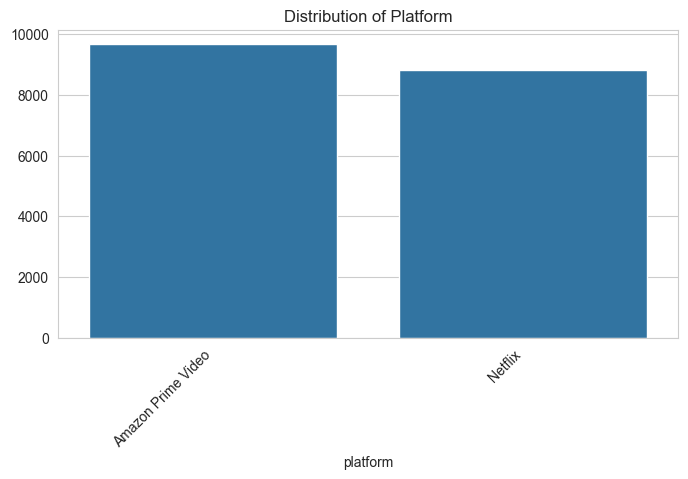


--- CONTENT_TYPE ---


,Count,Percentage
content_type,,
Movie,13945,75.48
TV Show,4530,24.52


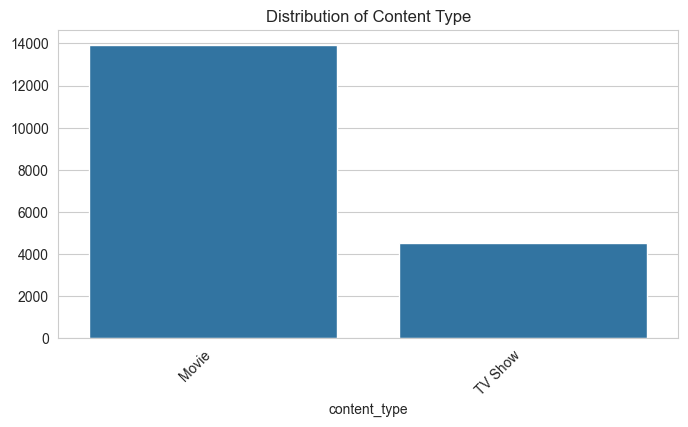


--- MATURITY_RATING ---


,Count,Percentage
maturity_rating,,
Unknown,9672,52.35
TV-MA,3207,17.36
TV-14,2160,11.69
TV-PG,863,4.67
R,799,4.32
PG-13,490,2.65
TV-Y7,334,1.81
TV-Y,307,1.66
PG,287,1.55


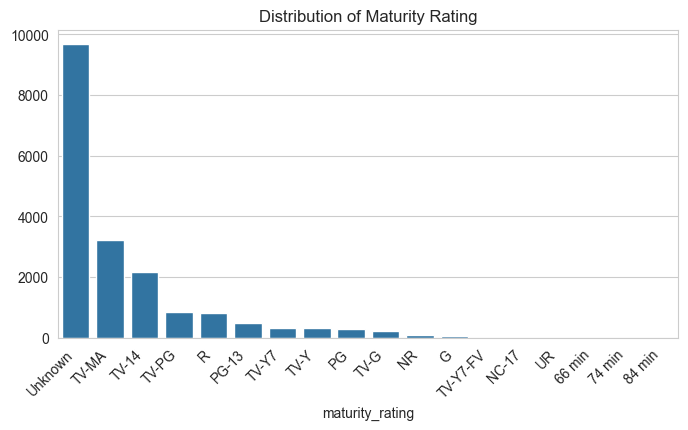


--- AGE_OF_VIEWERS ---


,Count,Percentage
age_of_viewers,,
General/Family,14386,77.87
Adults Only,4089,22.13


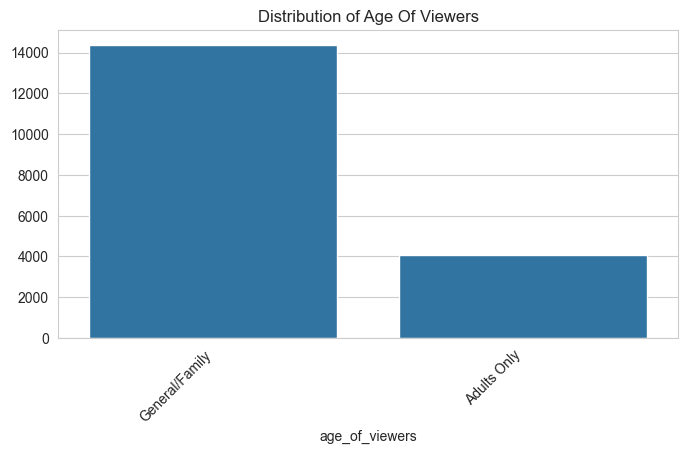

In [22]:
# Select the most relevant categorical columns for the summary
categorical_cols = ['platform', 'content_type', 'maturity_rating', 'age_of_viewers']

print("\n--- Categorical Summary: Counts and Frequencies ---")
for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    
    # Calculate value counts and normalize to get percentages
    counts = final_df[col].value_counts()
    percentages = final_df[col].value_counts(normalize=True).mul(100).round(2)
    
    # Combine counts and percentages into a single summary table
    summary_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    display(summary_df)
    
    # Simple Visualization for the top categories
    plt.figure(figsize=(8, 4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
# Code to generate this plot
plt.figure(figsize=(10, 6))
sns.histplot(final_df, x='release_year_numeric', kde=True, bins=30, color='skyblue')
plt.title('Distribution of Content Release Years')
plt.xlabel('Release Year')
plt.show()